# STEP 2 - Learning for matching
Consider the case in which the company can observe the type of each customer Ci.
Moreover, assume that the set of seeds is fixed to the optimal solution found when the
activation probabilities are known. On the other hand, suppose that the reward distributions
F(Dj, Ci) for the matching are unknown. Apply an upper confidence bound matching
algorithm in which the value of a matching is substituted with its upper confidence bound. Do
the same using a TS-like algorithm. Report the plots with the average (over a sufficiently
large number of runs) value and standard deviation of the cumulative regret, cumulative
reward, instantaneous regret, and instantaneous reward.

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm


In [137]:
class Environment:
    def __init__(self, probabilities):
        self.probabilities = probabilities

    def round(self, pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward

In [138]:
class Learner:
    def __init__(self, n_arms) -> None:
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, [reward])
        self.t += 1
        
class UCBLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.n_pulls = np.zeros(n_arms)  # count the number of times each arm has been pulled
        self.confidence = np.array([np.inf] * n_arms)
    
    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.n_pulls[pulled_arm] += 1
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.n_pulls[pulled_arm] - 1) + reward) / self.n_pulls[pulled_arm]
        for a in range(self.n_arms):
            n_samples = max(1, self.n_pulls[a])
            self.confidence[a] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else np.inf
        
        self.update_observations(pulled_arm, reward)
        
    def expectations(self):
        return self.empirical_means

In [139]:
class UCBMatching(UCBLearner):
    def __init__(self, n_arms, n_rows, n_cols):
        super().__init__(n_arms)
        self.n_rows = n_rows
        self.n_cols = n_cols
        assert n_arms == n_rows * n_cols

    def pull_arm(self):
        upper_conf = self.empirical_means + self.confidence
        upper_conf[np.isinf(upper_conf)] = 1e3
        row_ind, col_ind = linear_sum_assignment(-upper_conf.reshape(self.n_rows, self.n_cols))
        return (row_ind, col_ind)
    
    def update(self, pulled_arms, reward):
        self.t+=1
        pulled_arms_flat = np.ravel_multi_index(pulled_arms, (self.n_rows, self.n_cols))

        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            self.confidence[a] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else np.inf

        for pulled_arm, reward in zip(pulled_arms_flat, reward):
            self.update_observations(pulled_arm, reward)
            self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.t - 1) + reward) / self.t
            

    def expectations(self):
        return self.empirical_means

In [140]:
class TSLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms, 2))
        self.means = np.zeros(n_arms)  # Initialize the means array with zeros

    def pull_arm(self):
        idx = np.argmax(np.random.beta(self.beta_parameters[:, 0], self.beta_parameters[:, 1]))
        return idx
    
    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.beta_parameters[pulled_arm, 0] = self.beta_parameters[pulled_arm, 0] + reward
        self.beta_parameters[pulled_arm, 1] = self.beta_parameters[pulled_arm, 1] + 1.0 - reward
        for arm in range(self.n_arms):
            alpha = self.beta_parameters[arm, 0]
            beta = self.beta_parameters[arm, 1]
            if alpha == 1 and beta == 1: 
                self.means[arm] = 0
            else:
                self.means[arm] = alpha / (alpha + beta)

    def expectations(self):
        return self.means

In [141]:
class TSMatching(TSLearner):
    def __init__(self, n_arms, n_rows, n_cols):
        super().__init__(n_arms)
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.beta_parameters = np.ones((n_arms, 2))
        self.means = np.zeros(n_arms)
    
    def pull_arm(self):
        samples = np.random.beta(self.beta_parameters[:, 0], self.beta_parameters[:, 1])
        row_ind, col_ind = linear_sum_assignment(-samples.reshape(3, 3))
        return row_ind, col_ind
    
    def update(self, pulled_arms, reward):
        self.t+=1
        pulled_arms_flat = np.ravel_multi_index(pulled_arms, (self.n_rows, self.n_cols))
        
        for pulled_arm, reward in zip(pulled_arms_flat, reward):
            self.update_observations(pulled_arm, reward)
            self.beta_parameters[pulled_arm, 0] = self.beta_parameters[pulled_arm, 0] + reward
            self.beta_parameters[pulled_arm, 1] = self.beta_parameters[pulled_arm, 1] + 1.0 - reward
        
        for arm in range(self.n_arms):
            alpha = self.beta_parameters[arm, 0]
            beta = self.beta_parameters[arm, 1]
            if alpha == 1 and beta == 1: 
                self.means[arm] = 0
            else:
                self.means[arm] = alpha / (alpha + beta)
                
    def expectations(self):
        return self.means

In [142]:
def simulate_episode(init_prob_matrix, seeds:list, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    #set up seeds
    active_nodes=np.zeros(n_nodes)

    for seed in seeds:
        active_nodes[seed]=1

    history=np.array([active_nodes])

    newly_active_nodes=active_nodes

    t=0

    while (t<max_steps and np.sum(newly_active_nodes)>0):
        #retrieve probability of edge activations
        p = (prob_matrix.T*active_nodes).T
        activated_edges=p>np.random.rand(p.shape[0], p.shape[1])
        #remove activated edges
        prob_matrix=prob_matrix*((p!=0)==activated_edges)
        #update active nodes
        newly_active_nodes=(np.sum(activated_edges, axis=0)>0)*(1-active_nodes)
        #print(newly_active_nodes)
        active_nodes=np.array(active_nodes+newly_active_nodes)
        #print(active_nodes)
        history=np.concatenate((history, [newly_active_nodes]), axis=0)
        t+=1
    return history, active_nodes

def test_seed(seeds, prob_matrix, k, max_steps):
    reward = 0
    for i in range(k):
        history, active_nodes=simulate_episode(prob_matrix, seeds, max_steps)
        reward+=np.sum(active_nodes)
    return reward/k

def greedy_algorithm(init_prob_matrix, budget, k, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    seeds=[]
    for j in range(budget):
        rewards=np.zeros(n_nodes)

        for i in tqdm(range(n_nodes)):
            if i not in seeds:
                rewards[i]=test_seed([i]+seeds, prob_matrix, k, max_steps)
        seeds.append(np.argmax(rewards))

    return seeds

In [143]:
def hungarian_algorithm(matrix):
    m = -matrix.copy()  # Negate the matrix
    n_rows, n_cols = m.shape
    max_val = np.max(m)

    if n_rows > n_cols:
        m = np.pad(m, ((0, 0), (0, n_rows - n_cols)), mode='constant', constant_values=max_val)
    elif n_cols > n_rows:
        m = np.pad(m, ((0, n_cols - n_rows), (0, 0)), mode='constant', constant_values=max_val)

    assigned_rows, assigned_cols = linear_sum_assignment(m)

    assignment = np.zeros_like(m, dtype=int)
    assignment[assigned_rows, assigned_cols] = 1

    return assignment[:n_rows, :n_cols] * matrix, assignment[:n_rows, :n_cols]


def get_reward(node_class, product_class, rewards_parameters):
    return np.random.normal(rewards_parameters[0][node_class, product_class], rewards_parameters[1][node_class, product_class])


def clairvoyant(graph_probabilities, true_prob, customer_assignments, rewards_parameters, real_reward_parameters, n_exp, seeds=None):
    hungarian_matrix = hungarian_algorithm(rewards_parameters[0])[1]

    reward_per_experiment = [[] for i in range(n_exp)]

    if seeds == None:
        opt_seeds = greedy_algorithm(graph_probabilities, 3, 50, 100)
    else:
        opt_seeds = seeds

    for e in tqdm(range(n_exp)):

        history = simulate_episode(true_prob, opt_seeds, 10)[0]
        activation_flow = np.concatenate([np.where(row == 1)[0] for row in history]).tolist()
        class_activation_flow = customer_assignments[activation_flow]
        exp_reward = 0

        units = [3, 3, 3]
        

        while units > [0, 0, 0]:

            for customer in class_activation_flow:

                # find mean of matching reward
                nonzero_index = np.nonzero(hungarian_matrix[customer])
                product_class = int(nonzero_index[0][0])

                if units[product_class] != 0:
                    reward = get_reward(customer, product_class, real_reward_parameters)
                    units[product_class] = units[product_class] - 1

                else:
                    instock_units = [index for index, value in enumerate(units) if value != 0]
                    if instock_units:  # Check if instock_units is not empty before choosing
                        product_class = random.choice(instock_units)
                        reward = get_reward(customer, product_class, real_reward_parameters)
                        units[product_class] -= 1
                    else:
                        # Handle the case when units is empty (no available units)
                        reward = 0

                exp_reward = exp_reward + reward

            reward_per_experiment[e] = exp_reward

    return np.mean(reward_per_experiment), np.std(reward_per_experiment)

### Parameters Set Up

In [322]:
n_arms = 30
edge_rate=0.07
graph_structure = np.random.binomial(1, edge_rate, (n_arms, n_arms))
graph_probabilities = np.random.uniform(0.1, 0.9, (n_arms, n_arms)) * graph_structure
graph_probabilities


node_classes = 3
product_classes = 3
products_per_class = 3
T = 365

means = np.random.uniform(0.2, 0.8, size=(3,3))
std_dev = np.random.uniform(0.1, 0.2, size=(3, 3))
true_reward_parameters = (means, std_dev)
customer_assignments = np.random.choice([0,1,2], size=30)

### Estimating assignment reward distributions

#### Estimating means with MatchingUCB

In [340]:
p = true_reward_parameters[0]
n_experiments = 1
T= 365

learner = UCBMatching(p.size, *p.shape)
rewards_per_experiment = []
means_per_experiment = []
env = Environment(p)

means = []
for exp in tqdm(range(n_experiments)):
    experiment_means = np.zeros((T, 3, 3))  # Initialize a matrix for each experiment

    for t in range(T):
        pulled_arms = learner.pull_arm()
        reward = env.round(pulled_arms)
        learner.update(pulled_arms, reward)
        x = learner.expectations()
        experiment_means[t] = np.array(x).reshape(3, 3)
        
    means.append(experiment_means)

# Convert the list of lists to a numpy array
means = np.array(means)

# Calculate the mean estimates for each time step across all experiments
ucb_means= np.mean(means, axis=(0,))


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]


#### Estimating means with MatchingTS

In [341]:
p = true_reward_parameters[0]
n_experiments = 1

learner = TSMatching(p.size, *p.shape)
rewards_per_experiment = []
means_per_experiment = []
env = Environment(p)

means = []
for exp in tqdm(range(n_experiments)):
    experiment_means = np.zeros((T, 3, 3))  # Initialize a matrix for each experiment

    for t in range(T):
        pulled_arms = learner.pull_arm()
        reward = env.round(pulled_arms)
        learner.update(pulled_arms, reward)
        x = learner.expectations()
        experiment_means[t] = np.array(x).reshape(3, 3)
        
    means.append(experiment_means)

# Convert the list of lists to a numpy array
means = np.array(means)

# Calculate the mean estimates for each time step across all experiments
ts_means= np.mean(means, axis=(0,))


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


In [342]:
ucb_matching_rewards = []
ucb_matching_regret = []
ts_matching_rewards = []
ts_matching_regret = []
optimums = []

for t in range(T):
    #Compute optimums
    optimum = np.sum(hungarian_algorithm(true_reward_parameters[0])[0])
    optimums.append(optimum)
     
    #UCB performance
    ucb_matrix = ucb_means[t]
    ucb_matching_rewards.append(np.sum(hungarian_algorithm(ucb_matrix)[0]))
    ucb_matching_regret.append(optimum - np.sum(hungarian_algorithm(ucb_matrix)[0]))

    #TS performance
    ts_matrix = ts_means[t]
    ts_matching_rewards.append(np.sum(hungarian_algorithm(ts_matrix)[0]))
    ts_matching_regret.append(optimum - np.sum(hungarian_algorithm(ts_matrix)[0]))
    

    
    


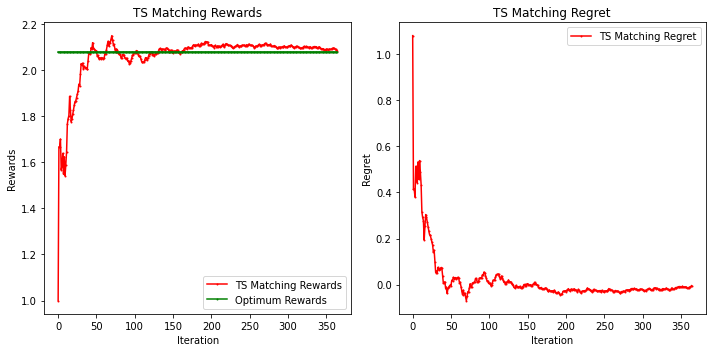

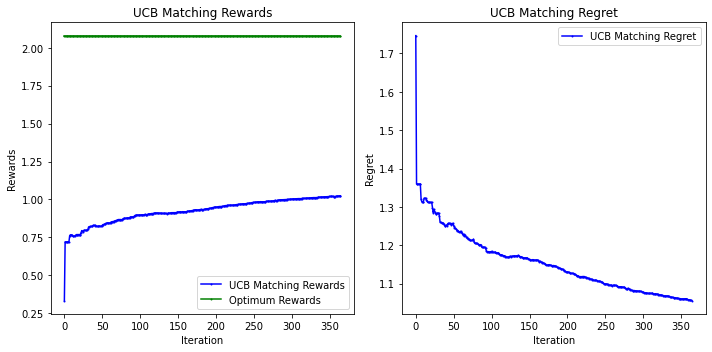

In [343]:
plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)
plt.plot(ts_matching_rewards, marker='o', markersize=1,label='TS Matching Rewards', color="red")
plt.plot(optimums, marker='o', markersize=1,label='Optimum Rewards', color="green")
plt.xlabel('Iteration')
plt.ylabel('Rewards')
plt.title('TS Matching Rewards')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ts_matching_regret, marker='o',markersize=1, color='red', label='TS Matching Regret')
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.title('TS Matching Regret')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)
plt.plot(ucb_matching_rewards, marker='o', markersize=1,label='UCB Matching Rewards', color = "blue")
plt.plot(optimums, marker='o', markersize=1,label='Optimum Rewards', color="green")
plt.xlabel('Iteration')
plt.ylabel('Rewards')
plt.title('UCB Matching Rewards')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ucb_matching_regret, marker='o', markersize=1, color='blue', label='UCB Matching Regret')
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.title('UCB Matching Regret')
plt.legend()

plt.tight_layout()
plt.show()


In [344]:
row_ind, col_ind = linear_sum_assignment(-p)
optimum = p[row_ind, col_ind].sum()


ucb_matching_rewards = []
ucb_matching_regret = []

for i in range(len(ucb_means)):
    matrix = ucb_means[i]
    row_ind, col_ind = linear_sum_assignment(-matrix)
    matching_rewards_sum = matrix[row_ind, col_ind].sum()
    ucb_matching_rewards.append(matching_rewards_sum)
    ucb_matching_regret.append(optimum - matching_rewards_sum)
    

ts_matching_rewards = []
ts_matching_regret = []

for i in range(len(ts_means)):
    matrix = ts_means[i]
    row_ind, col_ind = linear_sum_assignment(-matrix)
    matching_rewards_sum = matrix[row_ind, col_ind].sum()
    ts_matching_rewards.append(matching_rewards_sum)
    ts_matching_regret.append(optimum - matching_rewards_sum)
    

    
optimums = []
for i in range(len(ucb_means)):
    optimums.append(optimum)


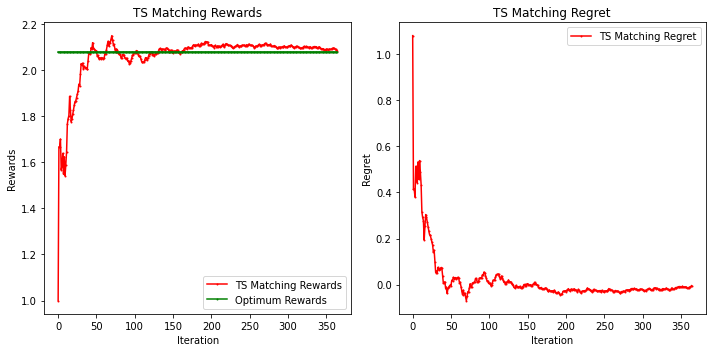

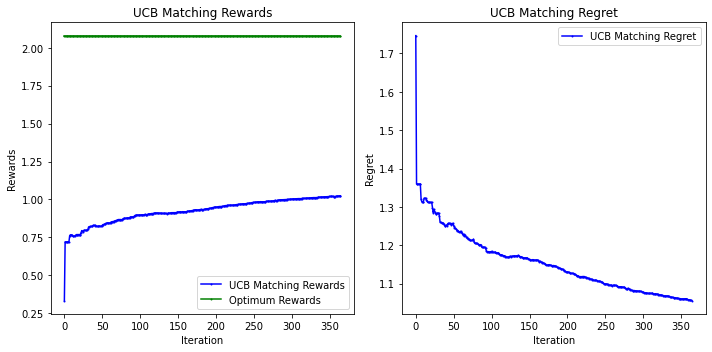

In [345]:
plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)
plt.plot(ts_matching_rewards, marker='o', markersize=1,label='TS Matching Rewards', color="red")
plt.plot(optimums, marker='o', markersize=1,label='Optimum Rewards', color="green")
plt.xlabel('Iteration')
plt.ylabel('Rewards')
plt.title('TS Matching Rewards')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ts_matching_regret, marker='o',markersize=1, color='red', label='TS Matching Regret')
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.title('TS Matching Regret')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)
plt.plot(ucb_matching_rewards, marker='o', markersize=1,label='UCB Matching Rewards', color = "blue")
plt.plot(optimums, marker='o', markersize=1,label='Optimum Rewards', color="green")
plt.xlabel('Iteration')
plt.ylabel('Rewards')
plt.title('UCB Matching Rewards')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ucb_matching_regret, marker='o', markersize=1, color='blue', label='UCB Matching Regret')
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.title('UCB Matching Regret')
plt.legend()

plt.tight_layout()
plt.show()


## Computing overall rewards

### Overall outcome when estimating matching rewards with UCBMatching

In [346]:
opt_seeds = greedy_algorithm(graph_probabilities, 3, 100, 10)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.01it/s]


In [347]:
std_dev = np.full(9, 0.05)
std_dev = std_dev.reshape(3,3)

In [348]:
import random 
T = 365
avg_ucb_overall_rew = []
avg_ts_overall_rew = []
std_dev_ucb_overall_rew = []
std_dev_ts_overall_rew = []



for index in range(T):
    
    ucb_round_score = clairvoyant(graph_probabilities, graph_probabilities, customer_assignments, (ucb_means[index],std_dev), true_reward_parameters, n_exp=50, seeds = opt_seeds)
    avg_ucb_overall_rew.append(ucb_round_score[0])
    std_dev_ucb_overall_rew.append(ucb_round_score[1])
    
    
    ts_round_score = clairvoyant(graph_probabilities, graph_probabilities, customer_assignments,(ts_means[index],std_dev), true_reward_parameters, n_exp=50, seeds = opt_seeds)
    avg_ts_overall_rew.append(ts_round_score[0])
    std_dev_ts_overall_rew.append(ucb_round_score[1])


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1999.82it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1666.59it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2083.30it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1850.38it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2272.55it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1923.23it/s]


In [349]:
optimum_means = []
optimum_std_dev = []
attempts = []

for i in range(100):
    z = clairvoyant(graph_probabilities, graph_probabilities, customer_assignments, true_reward_parameters, true_reward_parameters, 100, seeds=opt_seeds)
    attempts.append(z[0])
    
clairvoyant_output = max(attempts)

for t in range(T):
    optimum_means.append(clairvoyant_output)


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1999.94it/s]


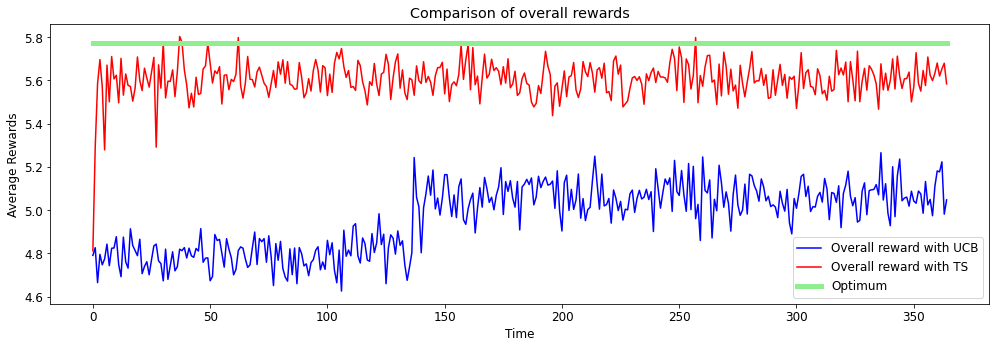

In [361]:
x = np.arange(T)
plt.rcParams.update({'font.size': 12})  # Adjust the font size as needed

plt.figure(figsize=(14, 5))


plt.plot(x, avg_ucb_overall_rew, label='Overall reward with UCB', color="blue")
plt.plot(x, avg_ts_overall_rew, label='Overall reward with TS', color="red")
plt.plot(x, optimum_means, label='Optimum', color="lightgreen", linewidth=5)

# Add error bars for UCB and TS

plt.xlabel('Time')
plt.ylabel('Average Rewards')
plt.title('Comparison of overall rewards')
plt.legend()

plt.tight_layout()
plt.show()


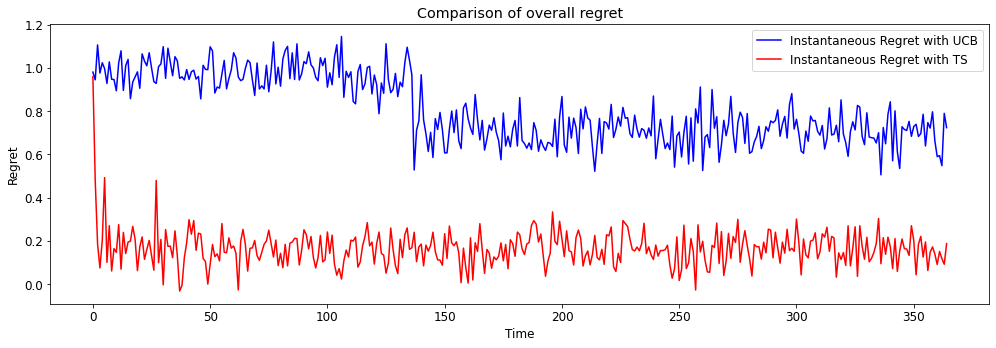

In [362]:
x = np.arange(T)

ucb_regret = np.subtract(optimum_means, avg_ucb_overall_rew)
ts_regret = np.subtract(optimum_means, avg_ts_overall_rew)


plt.figure(figsize=(14, 5))  
plt.plot(x, ucb_regret, label='Instantaneous Regret with UCB', color="blue")
plt.plot(x, ts_regret, label='Instantaneous Regret with TS', color="red")

plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('Comparison of overall regret')
plt.legend()



plt.tight_layout()
plt.show()

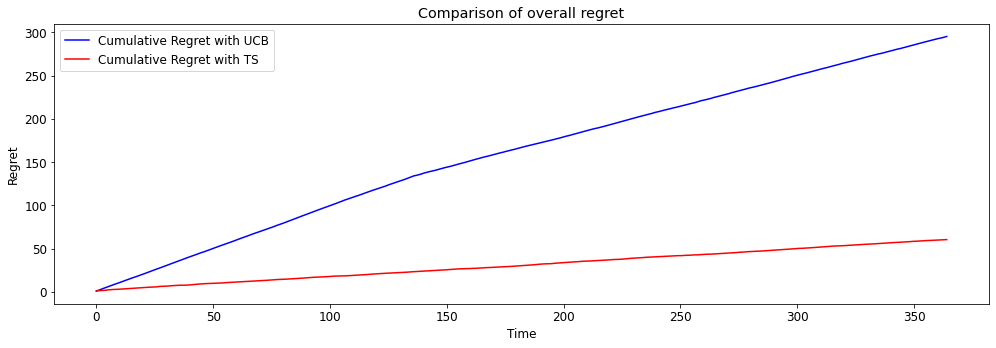

In [363]:
x = np.arange(T)

ucb_regret = np.subtract(optimum_means, avg_ucb_overall_rew)
ts_regret = np.subtract(optimum_means, avg_ts_overall_rew)
cumulative_ucb_regret = np.cumsum(ucb_regret)
cumulative_ts_regret = np.cumsum(ts_regret)


# Plot comparison between avg_ucb and avg_ts
plt.figure(figsize=(14, 5))  # Set figure size
plt.plot(x, cumulative_ucb_regret, label='Cumulative Regret with UCB', color="blue")
plt.plot(x, cumulative_ts_regret, label='Cumulative Regret with TS', color="red")

plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('Comparison of overall regret')
plt.legend()



plt.tight_layout()
plt.show()